In [1]:
import os
# NOTE: material: https://drive.google.com/drive/u/0/folders/14J6oWZzULqtXfIv99064Cs0iHVdeat22

In [2]:
# NOTE: access to directory
dir_project = os.path.abspath(".")
print(f"{dir_project=}")
os.chdir(dir_project)
print(f"{os.getcwd()=}")

dir_project='/root/Documents/Projects/augmented_safeguard/D-NeRF'
os.getcwd()='/root/Documents/Projects/augmented_safeguard/D-NeRF'


In [3]:

import json
import math
import time

import cv2
import imageio
import lpips
import numpy as np
import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mcubes
import trimesh
from tqdm import tqdm, trange


In [4]:
# NOTE: extended `config_parser()`

import NeRF.config_parser

def config_parser():
    import argparse
    parser = NeRF.config_parser.config_parser()

    # NOTE: D-NeRF training options
    # ------------------------------------------
    parser.add_argument("--nerf_type", type=str, default="original", help="nerf network type")
    parser.add_argument("--N_iter", type=int, default=500000, help="num training iterations")
    parser.add_argument("--do_half_precision", action="store_true", help="do half precision training and inference")

    parser.add_argument("--add_tv_loss", action="store_true", help="evaluate tv loss")
    parser.add_argument("--tv_loss_weight", type=float, default=1.e-4, help="weight of tv loss")
    # ------------------------------------------
    
    # NOTE: D-NeRF rendering options
    # ------------------------------------------
    parser.add_argument("--not_zero_canonical", action="store_true", help="if set zero time is not the canonic space")
    parser.add_argument("--use_two_models_for_fine", action="store_true", help="use two models for fine results")
    # ------------------------------------------

    return parser

In [5]:
# NOTE: parse arguments & load config
parser = config_parser()
filename_config = "configs/mutant.txt"
configs = NeRF.config_parser.load_config(parser, filename_config)
print(configs)

{'expname': 'mutant', 'basedir': './logs', 'datadir': './data/mutant', 'dataset_type': 'blender', 'nerf_type': 'direct_temporal', 'no_batching': 'True', 'not_zero_canonical': 'False', 'use_viewdirs': 'True', 'white_bkgd': 'True', 'lrate_decay': '500', 'N_iter': '800000', 'N_samples': '64', 'N_importance': '128', 'N_rand': '500', 'testskip': '1', 'precrop_iters': '500', 'precrop_iters_time': '100000', 'precrop_frac': '0.5', 'half_res': 'True', 'do_half_precision': 'False'}


In [6]:
# NOTE: assign configs to arguments

args = parser.parse_args(args=[])
args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']

args.nerf_type = configs['nerf_type']
args.no_batching = configs['no_batching']
args.not_zero_canonical = configs['not_zero_canonical']

args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])

args.N_iter = int(configs['N_iter'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.testskip = int(configs['testskip'])

args.precrop_iters = int(configs['precrop_iters'])
args.precrop_iters_time = int(configs['precrop_iters_time'])
args.precrop_frac = float(configs['precrop_frac'])

args.half_res = configs['half_res']
args.do_half_precision = configs['do_half_precision']

args.no_reload = True # NOTE: for now set to True as we'll implement training code

print(args)

device = torch.device("cuda")
DEBUG=False
print(device)

torch.set_default_tensor_type('torch.cuda.FloatTensor')

Namespace(N_importance=128, N_iter=800000, N_rand=500, N_samples=64, add_tv_loss=False, basedir='./logs', chunk=32768, datadir='./data/mutant', dataset_type='blender', do_half_precision='False', expname='mutant', factor=8, ft_path=None, half_res='True', i_embed=0, i_img=500, i_print=100, i_testset=50000, i_video=50000, i_weights=10000, lindisp=False, llffhold=8, lrate=0.0005, lrate_decay=500, multires=10, multires_views=4, nerf_type='direct_temporal', netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching='True', no_ndc=False, no_reload=True, not_zero_canonical='False', perturb=1.0, precrop_frac=0.5, precrop_iters=500, precrop_iters_time=100000, raw_noise_std=0.0, render_factor=0, render_only=False, render_test=False, shape='greek', spherify=False, testskip=1, tv_loss_weight=0.0001, use_two_models_for_fine=False, use_viewdirs='True', white_bkgd='True')
cuda


### Visualize Dataset

In [7]:
_datadir = "./data/mutant/"

with open(os.path.join(_datadir, "transforms_test.json"), "r") as fp:
    meta = json.load(fp)

print(str(meta)[:300])

_frames = meta['frames']
_frame = _frames[0]
print(_frame)

_fname = os.path.join(_datadir, _frame['file_path'] + ".png")
print(_fname)

import imageio.v2 as imageio
img = imageio.imread(_fname) # [800, 800, 4 = RGB+mask(synthetic; from Blender)]
print(img.shape)

{'camera_angle_x': 0.6911112070083618, 'frames': [{'file_path': './test/r_000', 'rotation': 0.3141592653589793, 'time': 0.0, 'transform_matrix': [[-0.9671632051467896, 0.0898933932185173, -0.23772795498371124, -0.958311915397644], [-0.254156231880188, -0.3420792818069458, 0.904647171497345, 3.646749
{'file_path': './test/r_000', 'rotation': 0.3141592653589793, 'time': 0.0, 'transform_matrix': [[-0.9671632051467896, 0.0898933932185173, -0.23772795498371124, -0.958311915397644], [-0.254156231880188, -0.3420792818069458, 0.904647171497345, 3.6467490196228027], [-7.450581485102248e-09, 0.9353613257408142, 0.35369348526000977, 1.4257838726043701], [0.0, 0.0, 0.0, 1.0]]}
./data/mutant/./test/r_000.png
(800, 800, 4)


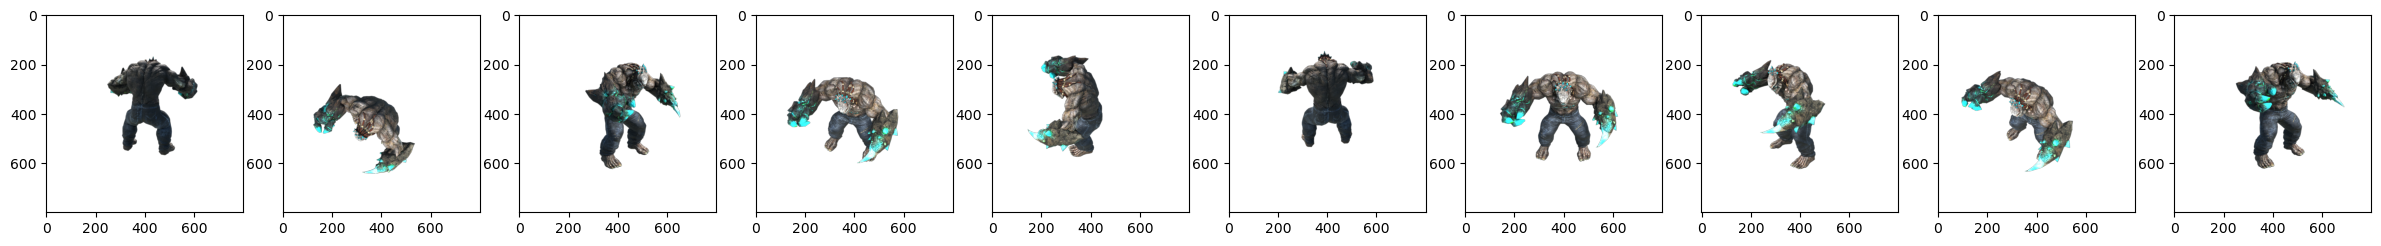

In [8]:
# NOTE: sequential visualization

fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

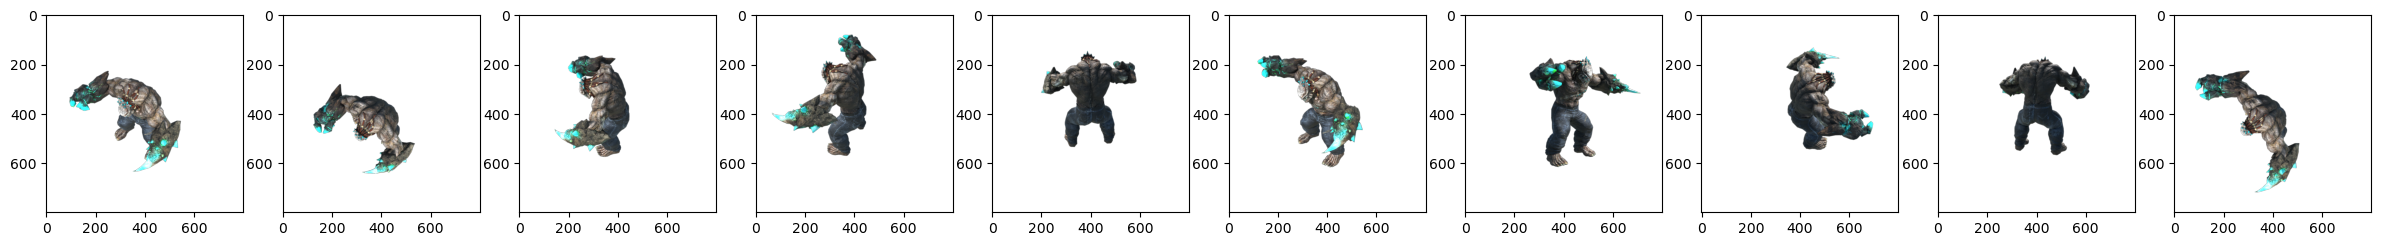

In [9]:
# NOTE: random shuffled visualization

import random
random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

(10, 800, 800, 4)


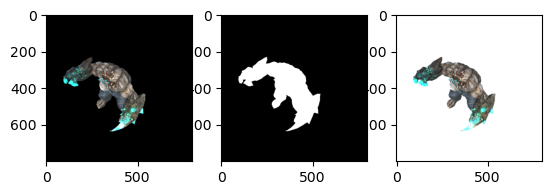

In [10]:
# NOTE: decomposed channel visualization

imgs = []
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)
    imgs.append(img)

imgs = (np.array(imgs) / 255.0).astype(np.float32) # [0., 1.]
print(imgs.shape)

imgs_orig = imgs[..., :3] # RGB
imgs_mask = imgs[..., -1] # mask

fig, axis = plt.subplots(1, 3)
axis[0].imshow(imgs_orig[0])
axis[1].imshow(imgs_mask[0], cmap="gray")

# NOTE: how plt operates with mask
imgs = imgs[..., :3] * imgs[..., -1:] + (1-imgs[..., -1:]) # `-1:`: broadcast 
axis[2].imshow(imgs[0])

In [13]:
# NOTE: load blender data

import NeRF.dataloader
import NeRF.pose

# NOTE: implement Blender data loader
def load_blender_data(basedir, half_res=False, testskip=1):

    """
    NOTE: if D-NeRF extended, marked as # as a suffix
    """

    images, poses, render_poses, hwf, i_split = NeRF.dataloader.load_blender_data(basedir, half_res, testskip)

    splits = ["train", "val", "test"]
    metas = {}

    # NOTE: load poses
    for s in splits:
        with open(os.path.join(basedir, f"transforms_{s}.json"), "r") as fp:
            metas[s] = json.load(fp)

    all_times = [] #

    counts = [0] # NOTE: start of `train` index
    for s in splits:
        meta = metas[s]
        times = [] # 
        skip = testskip # # NOTE: `time` should be re-normalized based on this

        for t, frame in enumerate(meta['frames'][::skip]):
            times.append(
                (cur_time := frame['time'] if 'time' in frame else float(t) / (len(meta['frames'][::skip]) - 1))
            ) #

        assert times[0] == 0, "Time must start at 0" # 

        times = np.array(times).astype(np.float32) #
        all_times.append(times) #

    times = np.concatenate(all_times, 0) #

    H, W = images[0].shape[:2]
    camera_angle_x = float(meta["camera_angle_x"])
    focal_length = 0.5*W / np.tan(camera_angle_x/2.) # NOTE: see handwritten note

    path_transforms_render = os.path.join(basedir, "transforms_render.json")
    if os.path.exists(path_transforms_render):
        
        with open(path_transforms_render, "r") as fp:
            meta = json.load(fp)
        
        render_poses = []
        for frame in meta["frames"]:
            render_poses.append(np.array(frame["transform_matrix"]))
        render_poses = np.array(render_poses).astype(np.float32)

    else:
        render_poses = torch.stack(
            [
                NeRF.pose.pose_spherical(theta=angle, phi=-30.0, radius=4.0) 
                for angle
                in np.linspace(-180, 180, 160+1)[:-1]
            ], dim=0
        )
    render_times = torch.linspace(0.0, 1.0, render_poses.shape[0])

    return imgs, poses, times, render_poses, render_times, [H, W, focal_length], i_split

# NOTE: validation?
images, poses, times, render_poses, render_times, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)